# On vs. Off Manifold Learning

February 22, 2022

The goal of this notebook is to replicate the experimental results of On vs. Off manifold learning from Sadtler et al. 2014 and subsequent studies.

Below, I follow the computational setup of Feulner and Clopath 2021

1. Train the recurrent weights `w_rec` of a network with random readout
2. Do PCA on activity, get matrix `C` with PCA
3. Find Decoder `D` with offline regression (i.e. on 50 trials without learning)

**Applying Perturbations**

*It is important to control for weak vs. strong perturbations. I do this by generating 200 different perturbations, and choosing perturbations that lead to cursor trajectories with (A) lower loss/MSE or (B) mean loss/MSE. Ideally we want both `T_wm` and `T_om` to have the same effect on loss/MSE*

4. Apply within manifold perturbation with `T_wm`
5. Apply out of manifold perturbation with `T_om`

## 1. Train Network

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("..")

In [2]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.rflo import RFLO
from algorithms.bptt import BPTT
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories

In [3]:
trial_duration = 20
n_in=4
frac_on = 0.4 # notice here the input duration - this usually makes the task easier

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

7it [00:00, 66.39it/s]

n_in: 4
n_rec: 200
n_out: 2
sig_in: 0.01
sig_rec: 0.1
sig_out: 0.01
tau_rec: 8
eta_in: 0.1
eta_rec: 0.1
eta_out: 0.1
driving_feedback: False
eta_fb: 0.5
sig_fb: 0.01
feedback_signal: position
velocity_transform: True
tau_vel: 2
dt_vel: 0.1
rng: <mtrand.RandomState object at 0x7fe2276e8828>


500it [00:05, 90.31it/s]


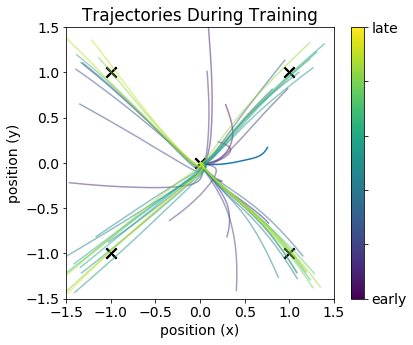

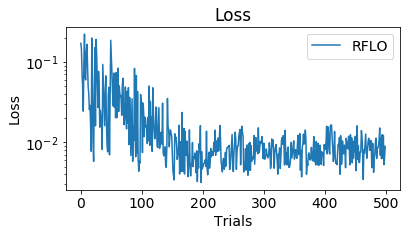

In [4]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=200,n_out=2,tau_rec=8,
               eta_in=0.1,eta_rec=0.1,eta_out=0.1,eta_fb=0.5,
               sig_in=0.01,sig_rec=0.1,sig_out=0.01, sig_fb=0.01,
               velocity_transform=True, tau_vel = 2, dt_vel = 0.1,
               driving_feedback=False,
               rng=np.random.RandomState(1))
params.print_params()

# Initialize RNN
net0 = RNN(params)

# initialize simulation
sim0 = Simulation(net0)

rflo = RFLO(net0,apply_to=['w_rec']) 
sim0.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=10)



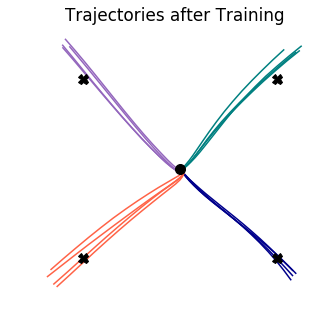

In [5]:
fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4])


50it [00:00, 124.05it/s]


(20, 200, 1)

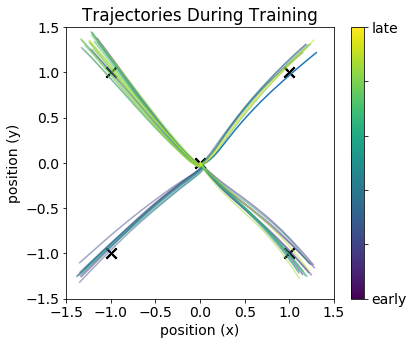

In [6]:
""" Run for 50 trials without learning
Save activity and position output for 50 trials.
This is then used for constructing a decoder.
"""

sim0.run_session(n_trials=50, tasks=[task1,task2,task3,task4], learn_alg=[], probe_types=['h','y_out','pos'], plot=True, plot_freq=1,train=False)

sim0.session_probes['h'][0].shape # 1 for each trial, then (20,200,1) matrix for 200 neurons

## 2. Do PCA on activity, get matrix `C` with PCA

In [7]:
""" Apply PCA """

# concatenate data
activity = sim0.session_probes['h'][0].squeeze()
print(activity.shape)

for i in range(1,len(sim0.session_probes['h'])):
    activity = np.vstack((activity,sim0.session_probes['h'][i].squeeze()))
    
print('n_samples,n_features: ',activity.shape)

(20, 200)
n_samples,n_features:  (1000, 200)


C:  (10, 200)


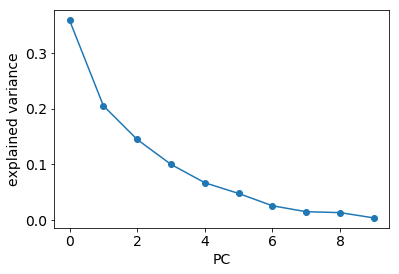

In [8]:
pca = PCA(n_components=10)
pca.fit(activity)
C = pca.components_

print('C: ',pca.components_.shape)
#plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.show()

In [9]:
""" Test that transformation is correct with sklearn"""
activity_lowD_pca = pca.transform(activity)

activity_lowD_test = C @ (activity.T - np.repeat(np.expand_dims(pca.mean_,1),activity.shape[0],axis=1))

np.sum(activity_lowD_pca - activity_lowD_test.T) #test

0.0

## 3. Find Decoder `D` with offline regression

In [10]:
""" Compare with cursor location """
pos = sim0.session_probes['pos'][0].squeeze()
print(pos.shape)

for i in range(1,len(sim0.session_probes['pos'])):
    pos = np.vstack((pos,sim0.session_probes['pos'][i].squeeze()))
print(pos.shape)

lr = LinearRegression(fit_intercept=False)
lr.fit((C @ activity.T).T, pos)
D = lr.coef_

print(D.shape)

(20, 2)
(1000, 2)
(2, 10)


100it [00:00, 103.12it/s]


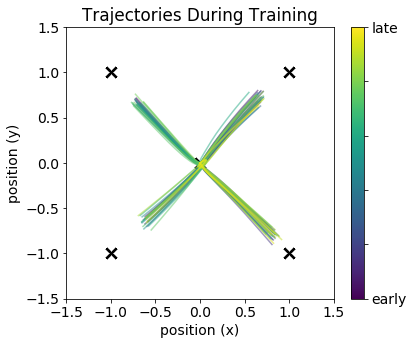

In [11]:
""" Test new decoder """

net1 = RNN(params)

net1.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))

net1.set_weights(w_out=D@C,w_m=(D@C).T) # set w_out and w_m

# initialize simulation, no learning here
sim1 = Simulation(net1)
# rflo1 = RFLO(net1,apply_to=['w_rec']) 
# sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo1], probe_types=['h','y_out','pos'], plot=True, plot_freq=10,train=True)
sim1.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[], probe_types=['h','y_out','pos'], plot=True, plot_freq=1,train=False)


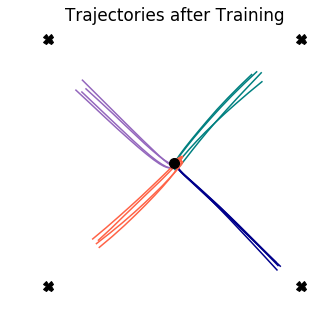

In [12]:
fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])


### _This feels a bit off_...surely the decoder should do better?

## 4A. Apply within manifold perturbation with `T_wm`

In [13]:
def cos_sim(a,b):
    """ cosine similarity between vectors """
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))



def permute_matrix(perm_dim,non_perm_dim,rng=np.random.RandomState(1)):
    
    """ Create permutation matrix where bottom rows are permuted (perm_dm)
    Permutes lowest PCs first..."""
    
    perm = rng.permutation(np.eye(perm_dim))
    perm1 = np.hstack((np.eye(non_perm_dim) ,np.zeros((non_perm_dim,perm_dim))))
    perm2 = np.hstack((np.zeros((perm_dim,non_perm_dim)),perm))
    perm3 = np.vstack((perm1,perm2))
    
    return perm3


""" Calculate Manifold overlap """

def activity_covariance(sim,C=None,verbose=True):
    
    """ Calculate activity covariance and manifold """
    h = sim.session_probes['h'][0].squeeze()
    
    if verbose: print(h.shape)

    for i in range(1,len(sim.session_probes['h'])):
        h = np.vstack((h,sim.session_probes['h'][i].squeeze()))
    if verbose: print(h.shape)

    cov = np.cov(h.T) # row is variable, col is observation
    
    beta = np.trace(C @ cov @ C.T) / np.trace(cov)
    
    return cov, beta

### Find reasonable T_wm matrices

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [46]:
def compare_permutation_matrices(n_comparisons=10,
                                 params=None,
                                 net=None,
                                 C=None,
                                 D=None,
                                 perm_dim=None,
                                 perturbation='within_manifold',
                                 plot=True,
                                 verbose=True):
    
    
    mean_list =[]
    perm_list = []
    overlap_list = []
    seeds = np.arange(0,n_comparisons)
    for seed in seeds:
        
        exp_rng = np.random.RandomState(seed)
        
        """ Initialize Test Network """
        net_test = RNN(params)
        net_test.set_weights(w_in=np.copy(net.w_in),w_rec=np.copy(net.w_rec),w_m=np.copy(net.w_m)) # keep "nonpermuted" internal matrix
        
        
        
        if verbose: print('RandomState',exp_rng)
        
        """ Permuting entire matrix leads to zero overlap """

        if perturbation == 'within_manifold':
            perm_wm = permute_matrix(perm_dim=perm_dim,non_perm_dim=C.shape[0]-perm_dim,rng=exp_rng)

            if verbose: print('\nperm_wm.shape = ',perm_wm.shape)
            if verbose: print('\nperm_wm: \n',perm_wm)

            T = np.copy(net.w_m).T
            T_wm = D @ perm_wm @ C
            
            perm_list.append(perm_wm)

            """ overlap of T and T_wm """
            overlap = cos_sim(T.ravel(),T_wm.ravel())
            overlap_list.append(overlap)
            if verbose: print('\nT_wm cosine overlap: {:.3f}'.format(overlap))
                
                
            # set w_out
            net_test.set_weights(w_out=T_wm)
                
                
        if perturbation == 'outside_manifold':
            
            """ Permuting entire matrix leads to zero overlap """
            perm_om = permute_matrix(perm_dim=perm_dim,non_perm_dim=C.shape[1]-perm_dim,rng=exp_rng)
            if verbose: print('\nperm_om.shape = ',perm_om.shape)

            T = np.copy(net.w_m).T
            T_om = D @ C @ perm_om
            
            perm_list.append(perm_om)

            """ overlap of T and T_om """
            overlap = cos_sim(T.ravel(),T_om.ravel())
            overlap_list.append(overlap)
            if verbose: print('\nT_om cosine overlap: {:.3f}'.format(overlap))
                
                
            # set w_out
            net_test.set_weights(w_out=T_om)


                
                
        

        
        

        # initialize simulation
        sim = Simulation(net_test)

        track_vars = TrackVars(net_test,apply_to=[]) # weight_transport doesn't matter here, because we are not learning w_out
        # note that train=False, but we still need a learning rule object to store the loss
        sim.run_session(n_trials=10, tasks=[task1,task2,task3,task4], learn_alg=[track_vars], probe_types=['loss'], plot=plot, plot_freq=1,train=True)

        # calculate mean MSE loss for each matrix
        mean_list.append(np.mean(np.asarray(sim.probes['loss'])))
        
        
    return perm_list,mean_list,overlap_list,seeds

## Find best and worst within manifold permutations

10it [00:00, 314.51it/s]
10it [00:00, 220.01it/s]
10it [00:00, 494.70it/s]
10it [00:00, 413.93it/s]
10it [00:00, 435.90it/s]
10it [00:00, 476.65it/s]
10it [00:00, 239.73it/s]
10it [00:00, 614.36it/s]
10it [00:00, 493.60it/s]
10it [00:00, 435.82it/s]
10it [00:00, 351.31it/s]
10it [00:00, 336.81it/s]
10it [00:00, 452.80it/s]
10it [00:00, 293.53it/s]
10it [00:00, 294.56it/s]
10it [00:00, 264.03it/s]
10it [00:00, 305.61it/s]
10it [00:00, 358.14it/s]
10it [00:00, 353.76it/s]
10it [00:00, 332.30it/s]
10it [00:00, 381.19it/s]
10it [00:00, 331.64it/s]
10it [00:00, 620.85it/s]
10it [00:00, 329.63it/s]
10it [00:00, 283.49it/s]
10it [00:00, 340.18it/s]
10it [00:00, 286.52it/s]
10it [00:00, 310.03it/s]
10it [00:00, 172.09it/s]
10it [00:00, 329.44it/s]
10it [00:00, 360.09it/s]
10it [00:00, 366.82it/s]
10it [00:00, 398.39it/s]
10it [00:00, 338.26it/s]
10it [00:00, 413.26it/s]
10it [00:00, 377.14it/s]
10it [00:00, 460.53it/s]
10it [00:00, 456.98it/s]
10it [00:00, 523.40it/s]
10it [00:00, 305.10it/s]


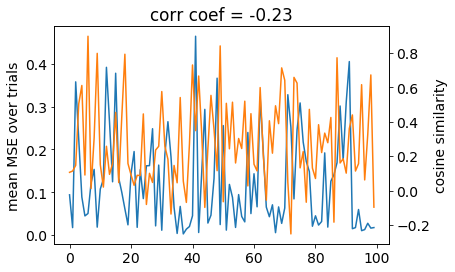

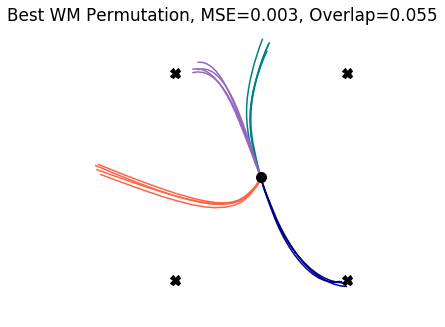

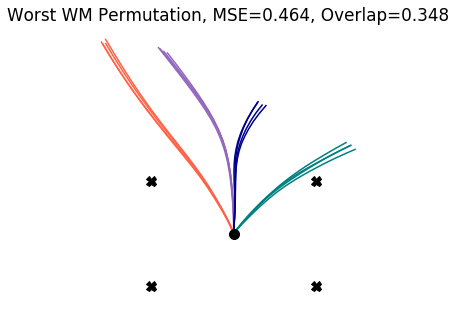

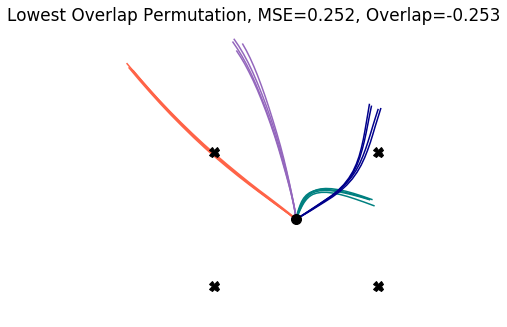

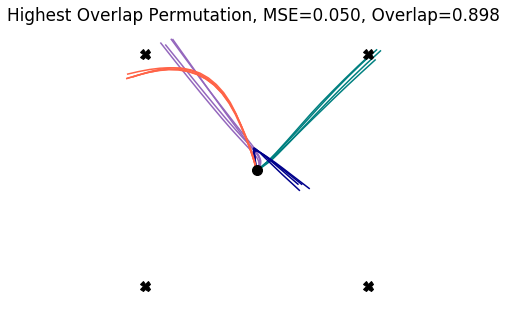

In [57]:
perm_list,mean_list,overlap_list,seeds = compare_permutation_matrices(n_comparisons=100,
                                                         params=params,
                                                         net=net1,
                                                         C=C,
                                                         D=D,
                                                         perm_dim=7,
                                                         perturbation='within_manifold',
                                                         plot=False,
                                                         verbose=False)



mean_min = np.argmin(mean_list)
mean_max = np.argmax(mean_list)

overlap_min = np.argmin(overlap_list)
overlap_max = np.argmax(overlap_list)

# plot trajectories for best and worst permutations
corr =np.corrcoef(np.asarray(mean_list),np.asarray(overlap_list))[0,1]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(mean_list,'C0')
ax2.plot(overlap_list,'C1')
ax1.set_ylabel('mean MSE over trials')
ax2.set_ylabel('cosine similarity')
ax1.set_title('corr coef = {:.2f}'.format(corr))
plt.show()


for ind,title in zip([mean_min,mean_max],['Best WM','Worst WM']):
    T_wm = D @ perm_list[ind] @ C       

    # """ Initialize Test Network """
    net_test = RNN(params)
    net_test.set_weights(w_in=np.copy(net1.w_in),w_rec=np.copy(net1.w_rec),w_m=np.copy(net1.w_m)) # keep "nonpermuted" internal matrix
    net_test.set_weights(w_out=T_wm)

    # initialize simulation
    sim_test = Simulation(net_test)

    rflo = RFLO(net_test,apply_to=['w_rec']) # weight_transport doesn't matter here, because we are not learning w_out

    fig = plot_trained_trajectories(sim=sim_test, tasks=[task1,task2,task3,task4],title=title+' Permutation, MSE={:.3f}, Overlap={:.3f}'.format(mean_list[ind],overlap_list[ind]))

    
for ind,title in zip([overlap_min,overlap_max],['Lowest Overlap','Highest Overlap']):
    T_wm = D @ perm_list[ind] @ C       

    # """ Initialize Test Network """
    net_test = RNN(params)
    net_test.set_weights(w_in=np.copy(net1.w_in),w_rec=np.copy(net1.w_rec),w_m=np.copy(net1.w_m)) # keep "nonpermuted" internal matrix
    net_test.set_weights(w_out=T_wm)

    # initialize simulation
    sim_test = Simulation(net_test)

    rflo = RFLO(net_test,apply_to=['w_rec']) # weight_transport doesn't matter here, because we are not learning w_out

    fig = plot_trained_trajectories(sim=sim_test, tasks=[task1,task2,task3,task4],title=title+' Permutation, MSE={:.3f}, Overlap={:.3f}'.format(mean_list[ind],overlap_list[ind]))

    
""" Find best MSE """    
T_wm = D @ perm_list[overlap_max] @ C   



## Find best and worst OUTSIDE manifold permutations

10it [00:00, 184.45it/s]
10it [00:00, 271.33it/s]
10it [00:00, 430.61it/s]
10it [00:00, 497.46it/s]
10it [00:00, 414.42it/s]
10it [00:00, 373.66it/s]
10it [00:00, 430.96it/s]
10it [00:00, 306.34it/s]
10it [00:00, 412.29it/s]
10it [00:00, 451.32it/s]
10it [00:00, 532.93it/s]
10it [00:00, 409.46it/s]
10it [00:00, 440.24it/s]
10it [00:00, 477.62it/s]
10it [00:00, 453.20it/s]
10it [00:00, 455.56it/s]
10it [00:00, 446.25it/s]
10it [00:00, 357.89it/s]
10it [00:00, 325.04it/s]
10it [00:00, 264.30it/s]
10it [00:00, 364.78it/s]
10it [00:00, 288.65it/s]
10it [00:00, 418.73it/s]
10it [00:00, 352.04it/s]
10it [00:00, 238.09it/s]
10it [00:00, 312.81it/s]
10it [00:00, 312.24it/s]
10it [00:00, 411.39it/s]
10it [00:00, 307.42it/s]
10it [00:00, 423.80it/s]
10it [00:00, 307.23it/s]
10it [00:00, 402.48it/s]
10it [00:00, 312.30it/s]
10it [00:00, 268.41it/s]
10it [00:00, 512.76it/s]
10it [00:00, 181.18it/s]
10it [00:00, 369.77it/s]
10it [00:00, 478.26it/s]
10it [00:00, 362.59it/s]
10it [00:00, 584.92it/s]


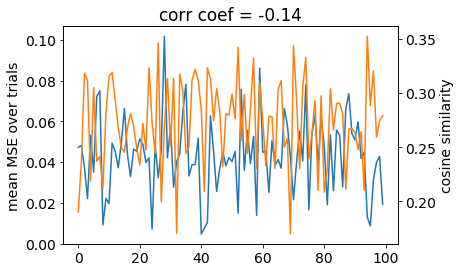

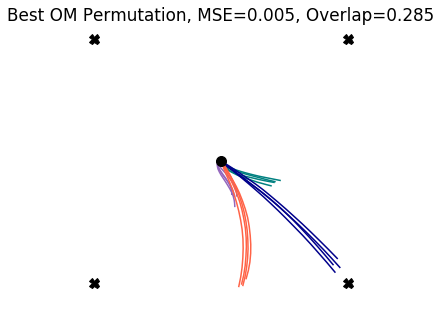

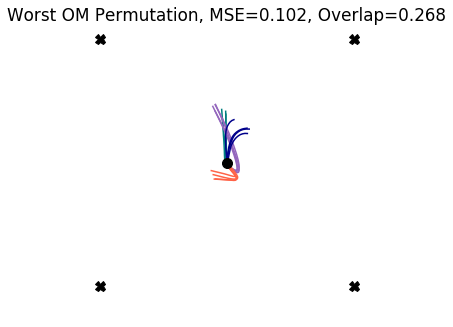

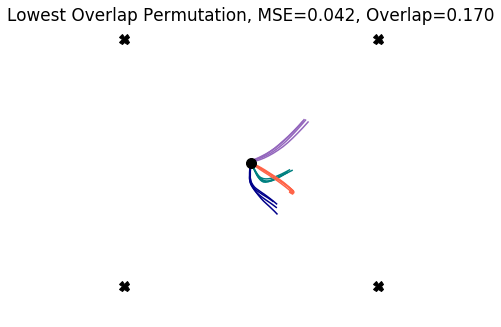

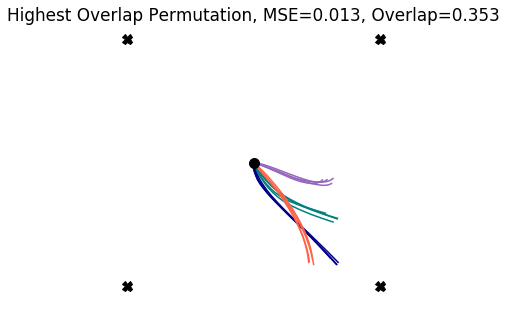

In [59]:
perm_list,mean_list,overlap_list,seeds = compare_permutation_matrices(n_comparisons=100,
                                                         params=params,
                                                         net=net1,
                                                         C=C,
                                                         D=D,
                                                         perm_dim=150,
                                                         perturbation='outside_manifold',
                                                         plot=False,
                                                         verbose=False)



mse_min = np.argmin(mean_list)
mse_max = np.argmax(mean_list)

overlap_min = np.argmin(overlap_list)
overlap_max = np.argmax(overlap_list)

# plot trajectories for best and worst permutations
corr =np.corrcoef(np.asarray(mean_list),np.asarray(overlap_list))[0,1]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(mean_list,'C0')
ax2.plot(overlap_list,'C1')
ax1.set_ylabel('mean MSE over trials')
ax2.set_ylabel('cosine similarity')
ax1.set_title('corr coef = {:.2f}'.format(corr))
plt.show()


for ind,title in zip([mse_min,mse_max],['Best OM','Worst OM']):
    T_om = D @ C @ perm_list[ind]      

    # """ Initialize Test Network """
    net_test = RNN(params)
    net_test.set_weights(w_in=np.copy(net1.w_in),w_rec=np.copy(net1.w_rec),w_m=np.copy(net1.w_m)) # keep "nonpermuted" internal matrix
    net_test.set_weights(w_out=T_om)

    # initialize simulation
    sim_test = Simulation(net_test)

    rflo = RFLO(net_test,apply_to=['w_rec']) # weight_transport doesn't matter here, because we are not learning w_out

    fig = plot_trained_trajectories(sim=sim_test, tasks=[task1,task2,task3,task4],title=title+' Permutation, MSE={:.3f}, Overlap={:.3f}'.format(mean_list[ind],overlap_list[ind]))

    
    
for ind,title in zip([overlap_min,overlap_max],['Lowest Overlap','Highest Overlap']):
    T_om = D @ C @ perm_list[ind] 

    # """ Initialize Test Network """
    net_test = RNN(params)
    net_test.set_weights(w_in=np.copy(net1.w_in),w_rec=np.copy(net1.w_rec),w_m=np.copy(net1.w_m)) # keep "nonpermuted" internal matrix
    net_test.set_weights(w_out=T_om)

    # initialize simulation
    sim_test = Simulation(net_test)

    rflo = RFLO(net_test,apply_to=['w_rec']) # weight_transport doesn't matter here, because we are not learning w_out

    fig = plot_trained_trajectories(sim=sim_test, tasks=[task1,task2,task3,task4],title=title+' Permutation, MSE={:.3f}, Overlap={:.3f}'.format(mean_list[ind],overlap_list[ind]))

    
#""" Find best MSE """    
#T_om = D @ C @ perm_list[mse_min] 
""" Find best Overlap """    
T_om = D @ C @ perm_list[overlap_max]
    

exp_rng = np.random.RandomState(0)
print('RandomState',exp_rng)



""" Permuting entire matrix leads to zero overlap """
#perm_wm = np.random.permutation(np.eye(D.shape[1]))

perm_wm = permute_matrix(perm_dim=7,non_perm_dim=3,rng=exp_rng)

print('\nperm_wm.shape = ',perm_wm.shape)
print('\nperm_wm: \n',perm_wm)

T = np.copy(net1.w_m).T
T_wm = D @ perm_wm @ C

""" overlap of T and T_wm """
print('\nT_wm cosine overlap: {:.3f}'.format(cos_sim(T.ravel(),T_wm.ravel())))







""" Permuting entire matrix leads to zero overlap """
#perm_om = np.random.permutation(np.eye(C.shape[1]))
perm_om = permute_matrix(perm_dim=190,non_perm_dim=10,rng=exp_rng)
print('\nperm_om.shape = ',perm_om.shape)


T_om = D @ C @ perm_om

""" overlap of T and T_om """
print('\nT_om cosine overlap: {:.3f}'.format(cos_sim(T.ravel(),T_om.ravel())))






500it [00:05, 97.58it/s] 


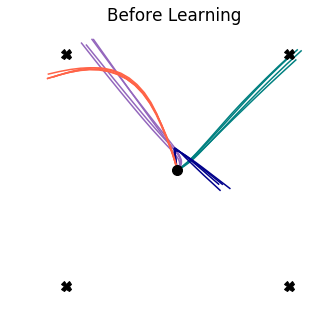

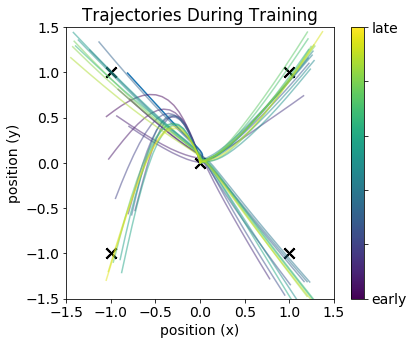

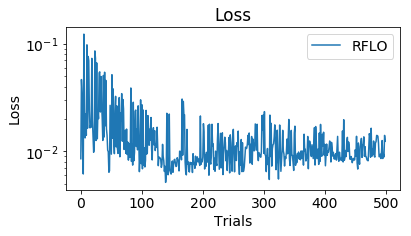

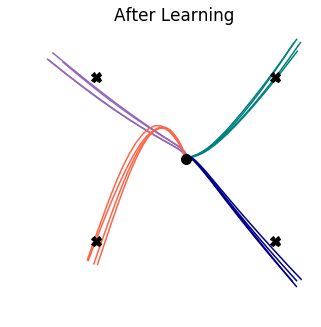

In [60]:
""" Initialize Networks """
net2 = RNN(params)
net2.set_weights(w_in=np.copy(net1.w_in),w_rec=np.copy(net1.w_rec),w_m=np.copy(net1.w_m)) # keep "nonpermuted" internal matrix
#net2.set_weights(w_in=np.copy(net1.w_in),w_rec=np.copy(net1.w_rec),w_m=T_wm.T)
net2.set_weights(w_out=T_wm)


# initialize simulation
sim2 = Simulation(net2)

rflo = RFLO(net2,apply_to=['w_rec'],weight_transport=False) # weight_transport doesn't matter here, because we are not learning w_out

fig = plot_trained_trajectories(sim=sim2, tasks=[task1,task2,task3,task4],title='Before Learning')

sim2.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=10)

fig = plot_trained_trajectories(sim=sim2, tasks=[task1,task2,task3,task4],title='After Learning')


100it [00:00, 406.00it/s]


(20, 200)
(2000, 200)
(20, 200)
(2000, 200)
manifold overlap: 0.9145


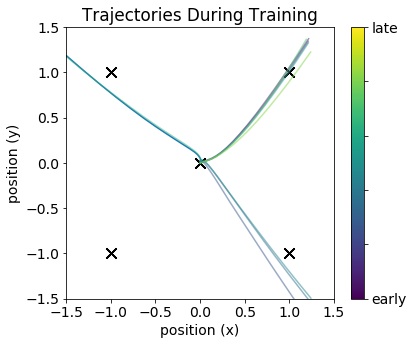

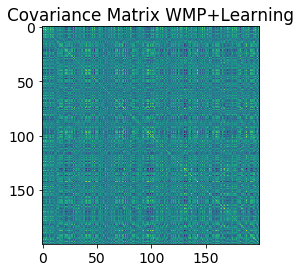

In [61]:

# run again without learning to get sample data
sim2.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[], probe_types=['h','y_out','pos'], plot=True, plot_freq=10,train=False)


cov_no_p, beta_no_p = activity_covariance(sim1,C=C)
cov_wm_p, beta_wm_p = activity_covariance(sim2,C=C)

print('manifold overlap: {:.4f}'.format(beta_wm_p/beta_no_p))

fig = plt.figure()
plt.imshow(cov_wm_p)
plt.title('Covariance Matrix WMP+Learning')
plt.show()

## 4B. Apply out of manifold perturbation with `T_om`

500it [00:04, 103.83it/s]


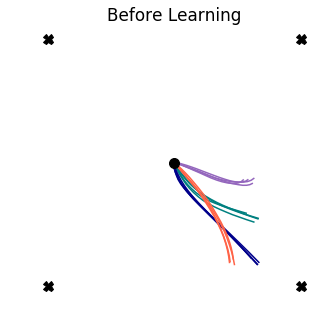

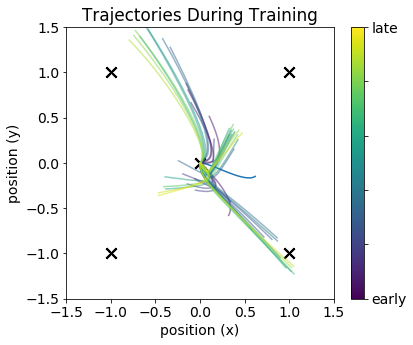

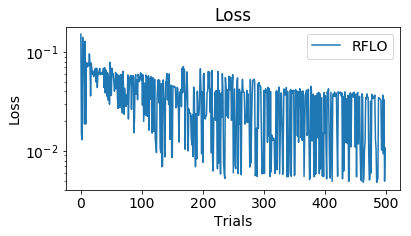

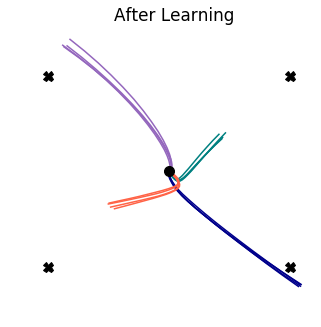

In [62]:
net3 = RNN(params)
net3.set_weights(w_in=np.copy(net1.w_in),w_rec=np.copy(net1.w_rec),w_m=np.copy(net1.w_m)) # keep "nonpermuted" internal matrix
#net3.set_weights(w_in=np.copy(net1.w_in),w_rec=np.copy(net1.w_rec),w_m=T_om.T)
net3.set_weights(w_out= T_om )

# initialize simulation
sim3 = Simulation(net3)

rflo = RFLO(net3,apply_to=['w_rec'],weight_transport=False) 

fig = plot_trained_trajectories(sim=sim3, tasks=[task1,task2,task3,task4],title='Before Learning')

sim3.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','y_out','pos'], plot=True, plot_freq=10)

fig = plot_trained_trajectories(sim=sim3, tasks=[task1,task2,task3,task4],title='After Learning')




100it [00:00, 111.92it/s]


(20, 200)
(2000, 200)
(20, 200)
(2000, 200)
manifold overlap: 0.8956


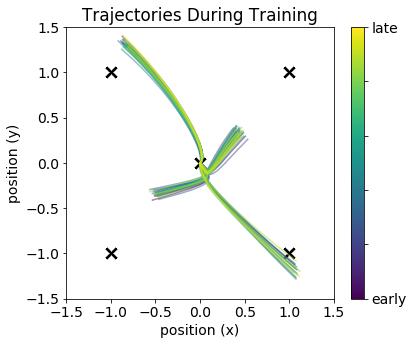

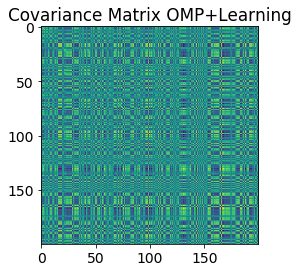

In [63]:

# run again without learning to get sample data
sim3.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[], probe_types=['h','y_out','pos'], plot=True, plot_freq=1,train=False)


cov_no_p, beta_no_p = activity_covariance(sim1,C=C)
cov_om_p, beta_om_p = activity_covariance(sim3,C=C)

print('manifold overlap: {:.4f}'.format(beta_om_p/beta_no_p))

fig = plt.figure()
plt.imshow(cov_om_p)
plt.title('Covariance Matrix OMP+Learning')
plt.show()


# Test REINFORCE out of manifold

These parameters seem to work nicely for REINFORCE
```
params4 = RNNparams(n_in=4,n_rec=200,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.01,eta_out=0.1,
               sig_in=0.01,sig_rec=0.5,sig_out=0.01,
               velocity_transform=True, tau_vel = 2, dt_vel = 0.25,
               rng=np.random.RandomState(0))
```

5000it [00:41, 120.90it/s]


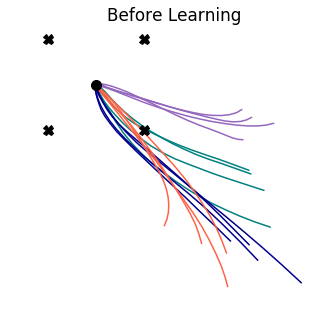

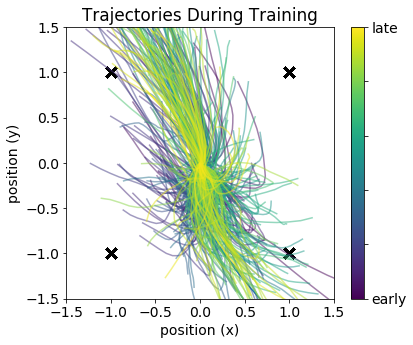

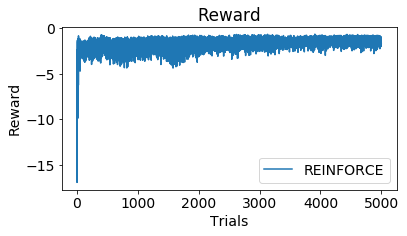

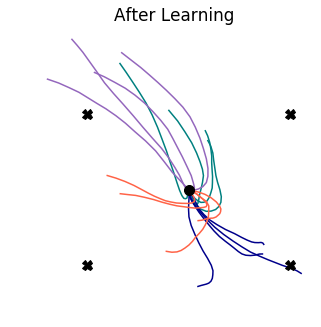

In [70]:
# note that I've increased the noise here

params4 = RNNparams(n_in=4,n_rec=200,n_out=2,tau_rec=8,
               eta_in=0.1,eta_rec=0.05,eta_out=0.1,
               sig_in=0.01,sig_rec=0.25,sig_out=0.01,
               velocity_transform=True, tau_vel = 2, dt_vel = 0.5,
               rng=np.random.RandomState(0))

net4 = RNN(params4)
net4.set_weights(w_in=np.copy(net1.w_in),w_rec=np.copy(net1.w_rec),w_m=np.copy(net1.w_m)) # keep "nonpermuted" internal matrix, although this doesn't matter for reinforce
#net3.set_weights(w_in=np.copy(net1.w_in),w_rec=np.copy(net1.w_rec),w_m=T_om.T)
net4.set_weights(w_out= T_om )

# initialize simulation
sim4 = Simulation(net4)

reinforce = REINFORCE(net4,apply_to=['w_rec'],online=True,tau_reward=5)

fig = plot_trained_trajectories(sim=sim4, tasks=[task1,task2,task3,task4],title='Before Learning')

sim4.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','y_out','pos'], plot=True, plot_freq=10)

fig = plot_trained_trajectories(sim=sim4, tasks=[task1,task2,task3,task4],title='After Learning')




100it [00:00, 112.81it/s]


(20, 200)
(2000, 200)
(20, 200)
(2000, 200)
manifold overlap: 0.5492


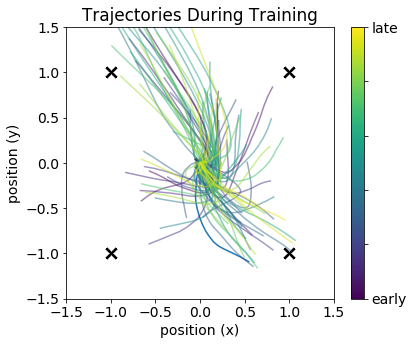

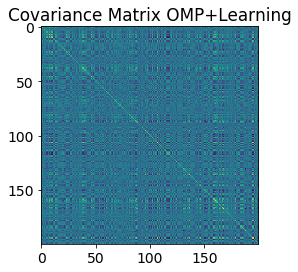

In [65]:

# run again without learning to get sample data
sim4.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[], probe_types=['h','y_out','pos'], plot=True, plot_freq=1,train=False)


cov_no_p, beta_no_p = activity_covariance(sim1,C=C)
cov_om_p, beta_om_p = activity_covariance(sim4,C=C)

print('manifold overlap: {:.4f}'.format(beta_om_p/beta_no_p))

fig = plt.figure()
plt.imshow(cov_om_p)
plt.title('Covariance Matrix OMP+Learning')
plt.show()


In [66]:
params

RNNparams(n_in=4, n_rec=200, n_out=2, sig_in=0.01, sig_rec=0.1, sig_out=0.01, tau_rec=8, eta_in=0.1, eta_rec=0.1, eta_out=0.1, driving_feedback=False, eta_fb=0.5, sig_fb=0.01, feedback_signal='position', velocity_transform=True, tau_vel=2, dt_vel=0.1, rng=<mtrand.RandomState object at 0x7fe2276e8750>)